In [1]:
# Writes a memo on county sheriff lethal incidents by arrests.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [3]:
plt.style.use('seaborn-v0_8-white')
pd.set_option('display.max_columns', 100)

In [4]:
# CBS station states plus others of interest
focus_states = ['CA','PA','NY','NJ','MN','FL','MI','CO','TX','IL','MA','MD','NC','OK']

In [5]:
staff_and_incidents = (
    pd.read_csv("../outputs/state_staff_and_incidents.csv")
)

staff_and_incidents.head()

,State,total_agency_staff,local police department,sheriffs office,pct_sheriff,pct_local_police,pct_other,year,total_incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff_incidents,pct_police_incidents,pct_others_incidents
0,LA,15683.0,5717.0,9796.0,0.624625,0.364535,0.010840,2022,19,11,11,0,0.578947,0.578947,0.000000
1,MT,3517.0,1166.0,1959.0,0.557009,0.331533,0.111459,2022,7,2,4,1,0.285714,0.571429,0.142857
2,ID,5700.0,2083.0,3085.0,0.541228,0.365439,0.093333,2022,8,6,4,0,0.750000,0.500000,0.000000
3,FL,68042.0,24196.0,36546.0,0.537109,0.355604,0.107287,2022,70,46,27,1,0.657143,0.385714,0.014286
4,WY,2729.0,975.0,1350.0,0.494687,0.357274,0.148040,2022,10,5,5,1,0.500000,0.500000,0.100000


In [6]:
# 2022 staff numbers by state
shortened = (
    staff_and_incidents
    .loc[ lambda x: x["year"] == 2022]
    .set_index("State")
    [[
        "local police department",
        "sheriffs office",
        "pct_sheriff",
        "pct_local_police",
    ]]
    .sort_values("sheriffs office", ascending = False)
)

shortened.head()



,local police department,sheriffs office,pct_sheriff,pct_local_police
State,,,,
CA,51418.0,50650.0,0.438111,0.444754
FL,24196.0,36546.0,0.537109,0.355604
TX,48728.0,32031.0,0.330557,0.502869
GA,13901.0,15880.0,0.452834,0.396401
NC,14734.0,13863.0,0.418379,0.444666


In [7]:
# read flagged incidents
incidents_flagged = (
    pd
    .read_csv(
        "../outputs/incidents_flagged.csv",
        parse_dates = ["Date of Incident (month/day/year)"],
    )
)

/tmp/ipykernel_9118/3919444457.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  pd


In [8]:
# shorten for easier merging
incidents_short = (
    incidents_flagged
    .assign(
        year = lambda f: f["Date of Incident (month/day/year)"].dt.year,
    )
    [["incident_uid", "State", "year", "sheriff", "police", "others"]]
)

incidents_short.head()

,incident_uid,State,year,sheriff,police,others
0,0,MI,2024,False,True,False
1,1,PA,2024,False,True,False
2,2,WY,2024,True,True,False
3,3,IL,2024,False,True,False
4,4,VA,2024,False,True,False


In [9]:
# incidents by state
incidents_states = (
    incidents_short
    .groupby(
        ["year", "State"]
    )
    .agg(
        incidents = ("incident_uid", "count"),
        sheriff_incidents = ("sheriff", "sum"),
        police_incidents = ("police", "sum"),
        other_incidents = ("others", "sum"),
    )
    .reset_index()
    .rename(
        columns = {
            "State": "state_abb"
        }
    )
    .assign(
        pct_sheriff = lambda x: x["sheriff_incidents"] / x["incidents"] * 100,
        pct_police = lambda x: x["police_incidents"] / x["incidents"] * 100,
        pct_others = lambda x: x["other_incidents"] / x["incidents"] * 100,
    )
    
)

incidents_states.head()

,year,state_abb,incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff,pct_police,pct_others
0,2013,AK,4,0,3,1,0.000000,75.000000,25.000000
1,2013,AL,21,8,12,1,38.095238,57.142857,4.761905
2,2013,AR,16,2,14,0,12.500000,87.500000,0.000000
3,2013,AZ,54,8,43,3,14.814815,79.629630,5.555556
4,2013,CA,191,63,128,4,32.984293,67.015707,2.094241


In [10]:
incidents_states["year"].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024], dtype=int32)

In [11]:
arrest_by_state = (
    pd
    .read_csv(
        "../outputs/arrests_by_state.csv",
    )
    .rename(
        columns = {
            "sheriffs office": "sheriff_arrests",
            "local police department": "police_arrests",
            "other": "other_arrests",
        }
    )
)

arrest_by_state.head()

,year,state_abb,police_arrests,sheriff_arrests,other_arrests
0,1960,AK,2400.0,0.0,0.0
1,1960,AL,27850.0,4549.0,0.0
2,1960,AR,9241.0,3049.0,0.0
3,1960,AZ,32953.0,5449.0,0.0
4,1960,CA,410865.0,123944.0,0.0


In [12]:
# sum over time period 2013 to 2023 to match MPV timeline
state_arrests_summed = (
    arrest_by_state
    .loc[ lambda x: (x["year"] >= 2013) & x["year"] <= 2023]
    .drop(columns = ["year"])
    .groupby("state_abb")
    .sum()
    .sort_values("sheriff_arrests", ascending = False)
    .reset_index()
)

state_arrests_summed.head()

,state_abb,police_arrests,sheriff_arrests,other_arrests
0,CA,78947524.0,15118179.0,1398343.0
1,FL,32697804.0,14931572.0,0.0
2,TX,55333261.0,8349361.0,0.0
3,SC,6608502.0,5881012.0,0.0
4,NC,14090065.0,5145678.0,0.0


In [13]:
# merge arrests with incidents data to get deaths/arrests over the 9 year period
incident_rate_summed= (
    incidents_states
    .loc[ lambda x: x["year"] <= 2023 ]
    .drop( columns = ["year"])
    .groupby("state_abb")
    .sum()
    .merge(
        # sum all years
        state_arrests_summed,
        on = ["state_abb"]
    )
    .assign(
        # per 100k arrests
        sheriff_incidents_per_arrest = lambda f: f["sheriff_incidents"] / f["sheriff_arrests"] * 100000,
        police_incidents_per_arrest = lambda f: f["police_incidents"] / f["police_arrests"] * 100000,
        other_incidents_per_arrest = lambda f: (f["other_incidents"] / f["other_arrests"] * 100000),
    )
    # the other incidents number is too low to be meaningful
    .replace([np.inf, -np.inf, np.nan], 0)
    .sort_values( by = ["sheriff_incidents"], ascending = False)
)

incident_rate_summed.head()

,state_abb,incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff,pct_police,pct_others,police_arrests,sheriff_arrests,other_arrests,sheriff_incidents_per_arrest,police_incidents_per_arrest,other_incidents_per_arrest
4,CA,1789,577,1158,86,357.643337,708.723957,54.053559,78947524.0,15118179.0,1398343.0,3.816597,1.466797,6.150136
9,FL,841,469,370,19,614.662209,482.883243,24.807425,32697804.0,14931572.0,0.0,3.140995,1.131574,0.000000
43,TX,1183,280,848,88,261.529321,787.272104,81.204199,55333261.0,8349361.0,0.0,3.353550,1.532532,0.000000
10,GA,483,207,264,33,465.111390,603.731168,74.246761,15918940.0,3923509.0,0.0,5.275890,1.658402,0.000000
27,NC,353,158,180,25,487.855983,570.662527,74.316259,14090065.0,5145678.0,0.0,3.070538,1.277496,0.000000


## Viz

(0.0, 15.112645179346051)

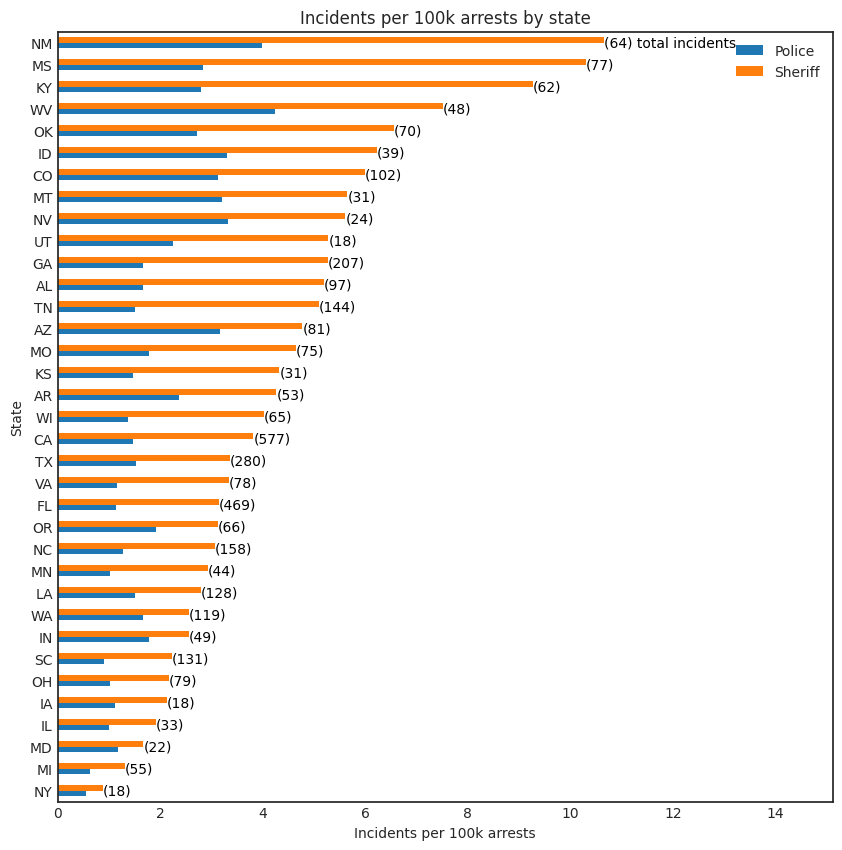

In [14]:
# in a grouped barh chart, plot the incidents per 100k arrests by state as well as the total number of sheriff incidents
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

subset_df = (
    incident_rate_summed
    .set_index("state_abb")
    # restrict analysis to states with at least 15 incidents
    .loc[ lambda f: f["sheriff_incidents"] >= 15]
    .sort_values( by = "sheriff_incidents_per_arrest")
)

(
    subset_df
    [["police_incidents_per_arrest", "sheriff_incidents_per_arrest"]]
    .plot(kind = "barh", ax = ax)
)

ax.set_title("Incidents per 100k arrests by state")
ax.set_xlabel("Incidents per 100k arrests")
ax.set_ylabel("State")
ax.legend(["Police", "Sheriff"])

# put the number of incidents at the end of the bars
for i, v in subset_df.reset_index().iterrows():
    rate = v["sheriff_incidents_per_arrest"]
    total = v["sheriff_incidents"]
    state = v["state_abb"]
    if state == "NM":
        ax.text(rate, i, f"({str(total)}) total incidents", color='black', va = "center")
    else:
        ax.text(rate, i, f"({str(total)})", color='black', va = "center")
# get max value of x axis from the ax object
maxx = ax.get_xlim()[1]
ax.set_xlim(0, maxx * 1.35)

---
---
---